In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

## Preliminary questions (exercise 1)
### a. What does each column of tx represent?
The first coloumn of tx corresponds to the offset term. The second column corresponds to the heights of the people.
### b. What does each row of tx represent?
Each row corresponds to the parameters of one datapoint.
### c. Why do we have 1’s in tx ?
Corresponds to the offset term.
### d. If we have heights and weights of 3 people, what would be the size of y and X ̃ ? What would tx[3,2] represent?
3 people would mean matrix Y has a size of (3,1), tx has a size of (3,2). tx[3,2] would be the height of the third person.


In [4]:
def compute_loss(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # compute loss by MSE
    # e = y - np.dot(tx,w)
    # MSE = (1/(2*len(y)))*np.dot(e.T, e)
    # return MSE
    
    # compute loss by MAE
    e = y - np.dot(tx,w)
    MAE = (1/len(y))*np.sum(np.absolute(e))
    return MAE
    
    # ***************************************************
    

In [5]:
w = np.array([1,2])
print(compute_loss(y, tx, w))

72.29392200210518


# 2. Grid Search

Fill in the function `grid_search()` below:

In [6]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # compute loss for each combination of w0 and w1.
    for i in range(0,len(grid_w0)):
        for j in range(0,len(grid_w1)):
            w = np.array([grid_w0[i],grid_w1[j]])
            losses[i,j] = compute_loss(y, tx, w) 
    # ***************************************************
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=4.8736571178918675, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.369 seconds


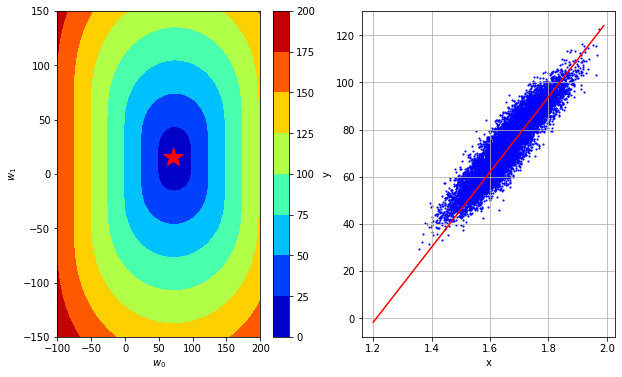

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # compute gradient vector
    e = y - np.dot(tx,w)
    GD = -(1/len(y))*np.dot(tx.T, e)
    
    return GD
    # ***************************************************
  

In [9]:
w1 = np.array([100,20])
print(compute_gradient(y, tx, w1))

w2 = np.array([50,10])
print(compute_gradient(y, tx, w2))

[26.706078    6.52028757]
[-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [10]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # Compute gradient and loss
        e = y - np.dot(tx,w)
        
        GD = -(1/len(y))*np.dot(tx.T, e)
        
        loss = (1/(2*len(y)))*np.dot(e.T, e)
        # ***************************************************
       
        # Update w by gradient
        w = w - gamma * GD
        # ***************************************************
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [11]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759168, w0=7.329392200210515, w1=1.3479712434988953
GD iter. 1/49: loss=2264.635056030003, w0=13.925845180399989, w1=2.5611453626479084
GD iter. 2/49: loss=1837.2777140793808, w0=19.86265286257051, w1=3.6530020698820165
GD iter. 3/49: loss=1491.1182670993753, w0=25.20577977652398, w1=4.635673106392713
GD iter. 4/49: loss=1210.7291150455721, w0=30.014593999082102, w1=5.520077039252339
GD iter. 5/49: loss=983.6139018819906, w0=34.34252679938441, w1=6.316040578826006
GD iter. 6/49: loss=799.6505792194902, w0=38.23766631965648, w1=7.032407764442307
GD iter. 7/49: loss=650.6402878628649, w0=41.74329188790136, w1=7.677138231496977
GD iter. 8/49: loss=529.9419518639978, w0=44.898354899321745, w1=8.257395651846178
GD iter. 9/49: loss=432.1762997049158, w0=47.73791160960009, w1=8.779627330160462
GD iter. 10/49: loss=352.9861214560593, w0=50.293512648850594, w1=9.249635840643318
GD iter. 11/49: loss=288.84207707448576, w0=52.59355358417606, w1=9.672643500077887
GD 

In [12]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [13]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    # ***************************************************
    # Implement stochastic gradient computation. It's the same as the usual gradient.
    e = y - np.dot(tx,w)
    GD = -(1/len(y))*np.dot(tx.T, e)
    # ***************************************************


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        # ***************************************************
        # Implement stochastic gradient descent.
        e = y - np.dot(tx,w)
        GD = -(1/len(y))*np.dot(tx.T, e)
        loss = (1/(2*len(y)))*np.dot(e.T, e)
  
        # Update w by gradient
        w = w - gamma * GD
        # store w and loss
        ws.append(w)
        losses.append(loss)
        # ***************************************************
        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [14]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2792.236712759168, w0=7.329392200210515, w1=1.3479712434988953
SGD iter. 1/49: loss=2264.635056030003, w0=13.925845180399989, w1=2.5611453626479084
SGD iter. 2/49: loss=1837.2777140793808, w0=19.86265286257051, w1=3.6530020698820165
SGD iter. 3/49: loss=1491.1182670993753, w0=25.20577977652398, w1=4.635673106392713
SGD iter. 4/49: loss=1210.7291150455721, w0=30.014593999082102, w1=5.520077039252339
SGD iter. 5/49: loss=983.6139018819906, w0=34.34252679938441, w1=6.316040578826006
SGD iter. 6/49: loss=799.6505792194902, w0=38.23766631965648, w1=7.032407764442307
SGD iter. 7/49: loss=650.6402878628649, w0=41.74329188790136, w1=7.677138231496977
SGD iter. 8/49: loss=529.9419518639978, w0=44.898354899321745, w1=8.257395651846178
SGD iter. 9/49: loss=432.1762997049158, w0=47.73791160960009, w1=8.779627330160462
SGD iter. 10/49: loss=352.9861214560593, w0=50.293512648850594, w1=9.249635840643318
SGD iter. 11/49: loss=288.84207707448576, w0=52.59355358417606, w1=9.6726435

In [15]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [16]:
import datetime
from helpers import *

# ***************************************************
# Reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
# ***************************************************


x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [17]:
y.shape, tx.shape

((202,), (202, 2))

In [18]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
# ***************************************************


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358533, w0=51.847464098448484, w1=7.724426406192441
GD iter. 1/49: loss=318.28212470159497, w0=67.401703327983, w1=10.041754328050121
GD iter. 2/49: loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574594
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249237, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225756, w1=11.034889001593537
GD ite

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [44]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # Compute subgradient gradient vector for MAE
    e = y - np.dot(tx,w)
    sign = np.sign(e)
    g = -(1/len(y))*np.dot(sign,tx)
     
    return g
    # ***************************************************
   

In [45]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        # compute subgradient and loss
        loss = compute_loss(y, tx, w)
        subgradient = compute_subgradient_mae(y, tx, w)
        
        # update w by subgradient
        w = w - subgradient * loss
        
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [46]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=74.06780585492638, w1=9.265323718695322e-14
SubGD iter. 1/499: loss=13.561731565085076, w0=73.66498214507236, w1=9.511349913666642
SubGD iter. 2/499: loss=7.416634966318797, w0=73.59155011570286, w1=13.501850638547138
SubGD iter. 3/499: loss=5.635119664315051, w0=73.36837705969039, w1=15.188374846791081
SubGD iter. 4/499: loss=5.368618587503157, w0=72.94313994384855, w1=15.502563495897409
SubGD iter. 5/499: loss=5.332294283084711, w0=72.78475496514307, w1=15.793972557729766
SubGD iter. 6/499: loss=5.312983046843682, w0=72.52173600242803, w1=15.983707637603938
SubGD iter. 7/499: loss=5.313206731511542, w0=72.67955402415609, w1=16.010522061356525
SubGD iter. 8/499: loss=5.311184980102729, w0=72.62696803425408, w1=15.99439047671623
SubGD iter. 9/499: loss=5.310625986426089, w0=72.62696803425408, w1=15.982178610923757
SubGD iter. 10/499: loss=5.3105979050536645, w0=72.62696803425408, w1=15.96996680970483
SubGD iter. 11/499: loss=5.3105853094798

In [40]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [47]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # implement stochastic subgradient descent.
        # compute subgradient and loss
        loss = compute_loss(y, tx, w)
        subgradient = compute_subgradient_mae(y, tx, w)
        
        # update w by subgradient
        w = w - subgradient * loss
        # ***************************************************

        
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [48]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=74.06780585492638, w0=74.06780585492638, w1=9.265323718695322e-14
SubSGD iter. 1/499: loss=13.561731565085076, w0=73.66498214507236, w1=9.511349913666642
SubSGD iter. 2/499: loss=7.416634966318797, w0=73.59155011570286, w1=13.501850638547138
SubSGD iter. 3/499: loss=5.635119664315051, w0=73.36837705969039, w1=15.188374846791081
SubSGD iter. 4/499: loss=5.368618587503157, w0=72.94313994384855, w1=15.502563495897409
SubSGD iter. 5/499: loss=5.332294283084711, w0=72.78475496514307, w1=15.793972557729766
SubSGD iter. 6/499: loss=5.312983046843682, w0=72.52173600242803, w1=15.983707637603938
SubSGD iter. 7/499: loss=5.313206731511542, w0=72.67955402415609, w1=16.010522061356525
SubSGD iter. 8/499: loss=5.311184980102729, w0=72.62696803425408, w1=15.99439047671623
SubSGD iter. 9/499: loss=5.310625986426089, w0=72.62696803425408, w1=15.982178610923757
SubSGD iter. 10/499: loss=5.3105979050536645, w0=72.62696803425408, w1=15.96996680970483
SubSGD iter. 11/499: loss=5.3

In [49]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>